## Project: 
- Classify Brain tumor MRI images using Deep learning

### Aim: 
- The aim of the project is to build a model using deep learning that can diagnose brain tumors from MRI (Magnetic Resonance Imaging) scans. Our aim is to detect if there is a tumor and then classify it in terms of grade, type, and specific location

### Data:
- The Brain Tumor MRI Dataset is available to download for free on Kaggle. This dataset contains roughly 7k MRI images, which are classified into 4 classes: glioma, meningioma, no tumor, and pituitary.

In [45]:
# Import Libraries
import pandas as pd
import os
from glob import glob
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# packages for data augmentation and machine modeling
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.metrics import Precision, Recall

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [10]:
TRAIN_DATA_FOLDER = '/Users/eugene/Personal_Projects/Real_ML_Project/brain_tumor_classification_cnn_model/braintumor_model_package/braintumor_model_package/datasets/braintumor-data/Training'
TEST_DATA_FOLDER = '/Users/eugene/Personal_Projects/Real_ML_Project/brain_tumor_classification_cnn_model/braintumor_model_package/braintumor_model_package/datasets/braintumor-data/Testing'

In [26]:
train_list = []
for class_folder_name in os.listdir(TRAIN_DATA_FOLDER):
    class_folder_path = os.path.join(TRAIN_DATA_FOLDER, class_folder_name)
    for image_path in glob.glob(os.path.join(class_folder_path, "*.jpg")):
        tmp = pd.DataFrame([image_path, class_folder_name]).T
        train_list.append(tmp)
# concatenate the final df
train_images_df = pd.concat(train_list, axis=0, ignore_index=True)
train_images_df.columns = ['image', 'label']
train_images_df.tail(10)

,image,label
5702,/Users/eugene/Personal_Projects/Real_ML_Projec...,meningioma
5703,/Users/eugene/Personal_Projects/Real_ML_Projec...,meningioma
5704,/Users/eugene/Personal_Projects/Real_ML_Projec...,meningioma
5705,/Users/eugene/Personal_Projects/Real_ML_Projec...,meningioma
5706,/Users/eugene/Personal_Projects/Real_ML_Projec...,meningioma
5707,/Users/eugene/Personal_Projects/Real_ML_Projec...,meningioma
5708,/Users/eugene/Personal_Projects/Real_ML_Projec...,meningioma
5709,/Users/eugene/Personal_Projects/Real_ML_Projec...,meningioma
5710,/Users/eugene/Personal_Projects/Real_ML_Projec...,meningioma
5711,/Users/eugene/Personal_Projects/Real_ML_Projec...,meningioma


In [28]:
train_images_df['image'][0]

'/Users/eugene/Personal_Projects/Real_ML_Project/brain_tumor_classification_cnn_model/braintumor_model_package/braintumor_model_package/datasets/braintumor-data/Training/pituitary/Tr-pi_0505.jpg'

In [29]:
train_images_df['label'].value_counts()

label
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64

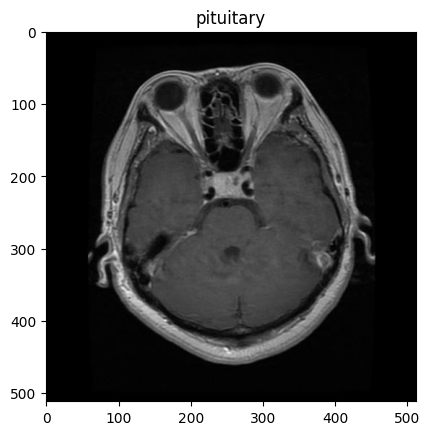

In [32]:

def plot_single_image(df, image_number):
    im = cv2.imread(df.loc[image_number, 'image'])
    plt.title(df.loc[image_number, 'label'])
    plt.imshow(im)
    
plot_single_image(train_images_df, 0)

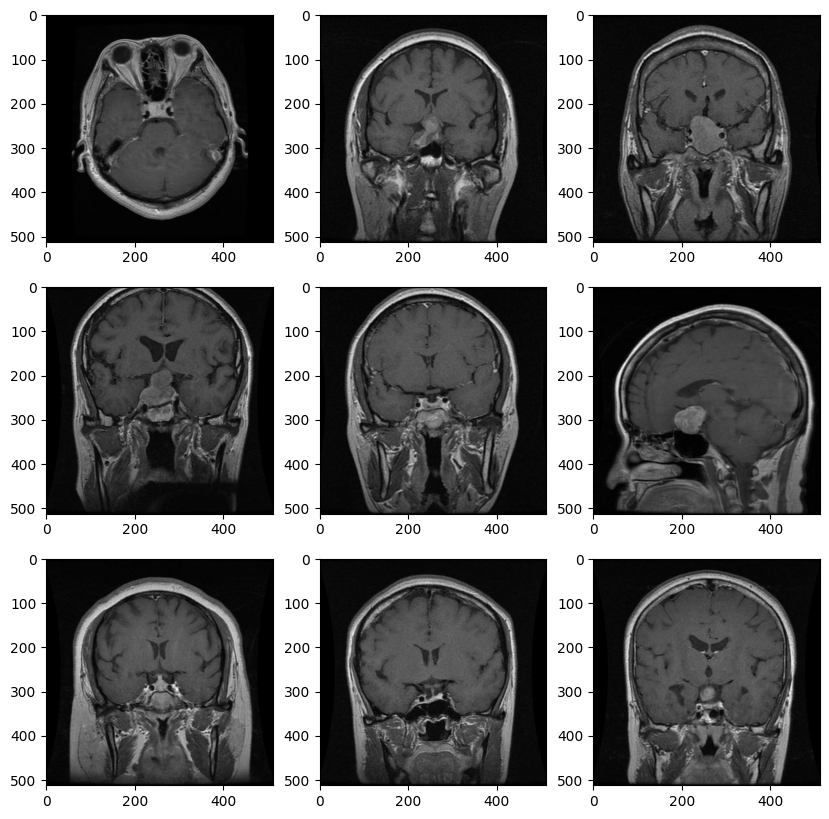

In [33]:

def plot_for_class(df, label):
    # function plots 9 images
    nb_rows = 3
    nb_cols = 3
    
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 10))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            tmp = df[df['label'] == label ]
            tmp.reset_index(drop=True, inplace=True)
            im = cv2.imread(tmp.loc[n, 'image'])          
            axs[i, j].imshow(im)
            n += 1 

plot_for_class(train_images_df, 'pituitary')

# Split Data to train and Val

In [38]:
# train_test_split

x_train, x_val, y_train, y_val = train_test_split(train_images_df, train_images_df['label'], test_size=0.20, random_state=101)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(4569, 2) (4569,) (1143, 2) (1143,)


In [39]:
y_train

3922        glioma
2201       notumor
1472       notumor
3554        glioma
4881    meningioma
           ...    
599      pituitary
5695    meningioma
1361     pituitary
1547       notumor
4959    meningioma
Name: label, Length: 4569, dtype: object

In [40]:
x_val.head()

,image,label
3665,/Users/eugene/Personal_Projects/Real_ML_Projec...,glioma
2398,/Users/eugene/Personal_Projects/Real_ML_Projec...,notumor
3836,/Users/eugene/Personal_Projects/Real_ML_Projec...,glioma
1799,/Users/eugene/Personal_Projects/Real_ML_Projec...,notumor
628,/Users/eugene/Personal_Projects/Real_ML_Projec...,pituitary


In [41]:
x_train.reset_index(drop=True, inplace=True)
x_val.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

# Image Resizing and Dataset Creation

In [43]:
batch_size = 32
image_shape = (150,150)

train_gen = ImageDataGenerator(preprocessing_function= preprocess_input)
val_gen = ImageDataGenerator(preprocessing_function= preprocess_input)

train_ds = train_gen.flow_from_dataframe(
    x_train,
    target_size = image_shape,
    batch_size = batch_size,
    x_col = 'image',
    y_col = 'label',
    class_mode = 'categorical',
    shuffle = True,
    seed = 101
)

Found 4569 validated image filenames belonging to 4 classes.


In [44]:
val_ds = val_gen.flow_from_dataframe(
    x_val,
    target_size = image_shape,
    batch_size = batch_size,
    x_col = 'image',
    y_col = 'label',
    class_mode = 'categorical',
    shuffle = False,
    seed = 101
)

Found 1143 validated image filenames belonging to 4 classes.


# Model Development

In [46]:
def make_model(
        input_size, 
        learning_rate, 
        size_inner,
        droprate):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(4)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy',
                 Precision(),
                 Recall()]
    )
    
    return model

In [47]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [48]:
input_size = 150
learning_rate = 0.001
size = 128
droprate = 0.3

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=10, validation_data=val_ds,
                   callbacks=[checkpoint])

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 146s 989ms/step - accuracy: 0.7126 - loss: 0.7460 - precision: 0.4759 - recall: 0.8135 - val_accuracy: 0.8591 - val_loss: 0.3949 - val_precision: 0.4701 - val_recall: 0.9851
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 140s 979ms/step - accuracy: 0.8757 - loss: 0.3418 - precision: 0.4909 - recall: 0.9830 - val_accuracy: 0.8828 - val_loss: 0.3236 - val_precision: 0.4900 - val_recall: 0.9904
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 141s 981ms/step - accuracy: 0.9004 - loss: 0.2737 - precision: 0.4861 - recall: 0.9897 - val_accuracy: 0.8889 - val_loss: 0.3079 - val_precision: 0.5291 - val_recall: 0.9878
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 141s 983ms/step - accuracy: 0.9197 - loss: 0.2407 - precision: 0.5197 - recall: 0.9893 - val_accuracy: 0.8941 - val_loss: 0.2946 - val_precision: 0.5594 - val_recall: 0.9851
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 140s 975ms/step - accuracy: 0.9318 - loss: 0.1938 - precision: 0.5496 - recall: 0.9901 - val_accuracy: 0

# Model Evaluation and Prediction

In [49]:
model = keras.models.load_model('xception_v4_1_10_0.920.keras')

In [56]:
test_list = []
for class_folder_name in os.listdir(TEST_DATA_FOLDER):
    class_folder_path = os.path.join(TEST_DATA_FOLDER, class_folder_name)
    for image_path in glob(os.path.join(class_folder_path, "*.jpg")):
        tmp = pd.DataFrame([image_path, class_folder_name]).T
        train_list.append(tmp)
# concatenate the final df
test_image_df = pd.concat(train_list, axis=0, ignore_index=True)
test_image_df.columns = ['image', 'label']
test_image_df.tail(10)

,image,label
14036,/Users/eugene/Personal_Projects/Real_ML_Projec...,meningioma
14037,/Users/eugene/Personal_Projects/Real_ML_Projec...,meningioma
14038,/Users/eugene/Personal_Projects/Real_ML_Projec...,meningioma
14039,/Users/eugene/Personal_Projects/Real_ML_Projec...,meningioma
14040,/Users/eugene/Personal_Projects/Real_ML_Projec...,meningioma
14041,/Users/eugene/Personal_Projects/Real_ML_Projec...,meningioma
14042,/Users/eugene/Personal_Projects/Real_ML_Projec...,meningioma
14043,/Users/eugene/Personal_Projects/Real_ML_Projec...,meningioma
14044,/Users/eugene/Personal_Projects/Real_ML_Projec...,meningioma
14045,/Users/eugene/Personal_Projects/Real_ML_Projec...,meningioma


In [57]:
test_image_df.shape, train_images_df.shape

((14046, 2), (5712, 2))

In [59]:
# create a new variable to hold all actual labels of each image
test_actual_class = test_image_df['label']
test_actual_class

# drop the label column from the test dataframe
test_image_df.drop(columns=['label'], inplace=True)
test_image_df.head()

,image
0,/Users/eugene/Personal_Projects/Real_ML_Projec...
1,/Users/eugene/Personal_Projects/Real_ML_Projec...
2,/Users/eugene/Personal_Projects/Real_ML_Projec...
3,/Users/eugene/Personal_Projects/Real_ML_Projec...
4,/Users/eugene/Personal_Projects/Real_ML_Projec...


In [60]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)


test_ds = test_gen.flow_from_dataframe(
    dataframe=test_image_df,
    x_col="image",
    target_size=image_shape,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
)

Found 14046 validated image filenames.


In [62]:
pred = model.predict(test_ds)
len(pred)
pred[:3]

439/439 ━━━━━━━━━━━━━━━━━━━━ 357s 812ms/step


array([[ 0.3140295 ,  2.100473  , -4.480823  ,  5.6340322 ],
       [-2.616268  ,  2.6729527 ,  0.5059322 ,  5.437151  ],
       [-0.9337346 , -0.08617175, -1.5569576 ,  4.4591064 ]],
      dtype=float32)

In [94]:
pred_classes =  pred.argmax(axis=1)
list(pred_classes)

[3,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,


In [77]:
data_class = test_actual_class.unique()
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(data_class)
class_num = le.transform(data_class)
print(class_num)
class_dict = dict(zip(data_class, class_num))
class_dict

[3 2 0 1]


{'pituitary': 3, 'notumor': 2, 'glioma': 0, 'meningioma': 1}

In [93]:
result = {value:key for key, value in class_dict.items()}
result_class =  [result[i] for i in pred_classes]
result_class

['pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'meningioma',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'glioma',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituit

In [90]:
# converting our actual test class labels to arrays
import numpy as np
def get_class_num(data):
    if data == 'pituitary':
        return 3
    elif data == 'notumor':
        return 2
    elif data == 'glioma':
        return 0
    else:
        return 1
        

actual_values =  test_actual_class.apply(lambda x: get_class_num(x))
actual_classes = np.array(actual_values)

In [91]:
from sklearn.metrics import  accuracy_score
accuracy_score(actual_classes, pred_classes, normalize=True, sample_weight=None)

0.9622668375338175

In [92]:
from sklearn.metrics import  classification_report

print(classification_report(actual_classes, pred_classes))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3242
           1       0.92      0.94      0.93      3290
           2       0.99      0.99      0.99      4000
           3       0.98      0.96      0.97      3514

    accuracy                           0.96     14046
   macro avg       0.96      0.96      0.96     14046
weighted avg       0.96      0.96      0.96     14046



<Figure size 640x480 with 0 Axes>

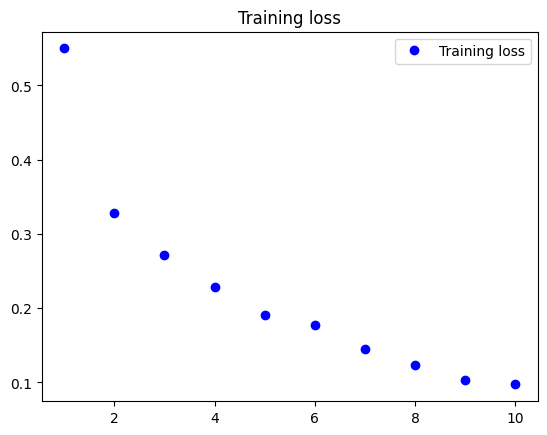

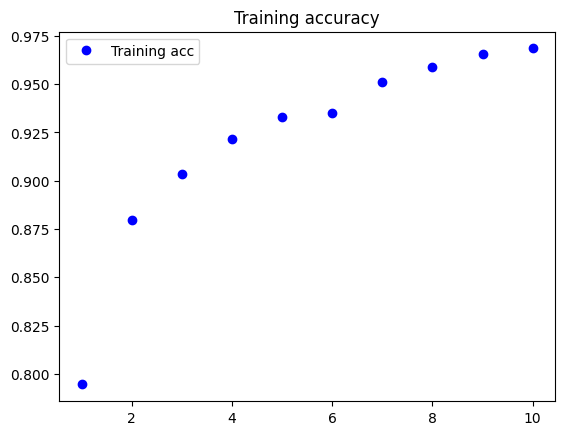

<Figure size 640x480 with 0 Axes>

In [95]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()

In [ ]:
# img_size = 150

# def img_resize(df, n):
#     img = cv2.imread(train_data['image'][0])
#     im = cv2.resize(img, (img_size, img_size))
#     return im.shape

In [ ]:
# img_size = 150

# def resize_and_create_dataset(data, img_size):

#     img_list =  []
#     for image in data:
#         # loading and resizing
#         obj_img = load_img(image, target_size=(img_size, img_size))
#         # converting images to array
#         obj_arr = img_to_array(obj_img, dtype='float64')
#         img_list.append(obj_arr)

#     final_img_array = np.array(img_list)
#         # normalizing the dataset
#     dataset_norm = normalize( final_img_array, axis=-1, order=2)
#     print(dataset_norm.shape)
#     return dataset_norm